>> Amr Abdelaziz Attia Mohamed 7447



## Pins face recognition

Some needed imports for the code

In [13]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

reading the zip file and making classification

In [14]:
import zipfile
from google.colab import files
# Step 2: Upload the ZIP file
print("Please upload the dataset ZIP file.")
# zip_file = 'C:/Users/amrka/Desktop/Multiclass Classification with Fashion MNIST.zip'
uploaded = files.upload()
# Step 3: Unzip the uploaded file
zip_file = list(uploaded.keys())[0]  # Get the name of the uploaded file
print(f"Unzipping {zip_file}...")

# Extract to a specified directory (you can change '/content/dataset' if needed)
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

print("Unzipping completed.")

# Step 4: Set the data directory
data_dir = '/content/dataset'  # Adjust this path if your dataset is in a subfolder

# Path to dataset directory and face detection model
# data_dir = 'C:/Users/amrka/Desktop/bonus/105_classes_pins_dataset'  # Update with the dataset path
face_model_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(face_model_path)
# # Path to dataset directory and face detection model
# data_dir = '105_classes_pins_dataset/'  # Update with the dataset path
# face_model_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
# face_cascade = cv2.CascadeClassifier(face_model_path)

Make a function that crop the face on the needed area only and resize the image again

In [15]:
def crop_face(image):
    # Ensure the image is in the correct format (uint8)
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) > 0:
        x, y, w, h = faces[0]
        cropped_face = image[y:y+h, x:x+w]  # Crop the face
        # Resize cropped face to 100x100
        return cv2.resize(cropped_face, (100, 100))
    
    # Return a blank image if no face is detected (100x100)
    return np.zeros((100, 100, 3), dtype=np.uint8)  # Blank image



Class that detect the face and its dimentions in the image

In [16]:
class CustomDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, *args, **kwargs)
        for batch_x, batch_y in generator:
            # Check each image before cropping
            batch_cropped = np.array([crop_face(img) for img in batch_x])
            yield batch_cropped, batch_y


Make error if file directory not exists

In [17]:
# Check if the dataset directory exists
if not os.path.exists(data_dir):
    raise ValueError("Dataset directory does not exist. Please check the path.")

- Creating a regular image data generator

- Counting the classes we have in the dataset

- Creating the train generator

- Creating the validate generator

In [18]:
# Create a regular ImageDataGenerator to get class indices
base_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

# Use this generator to get class indices
class_generator = base_datagen.flow_from_directory(
    data_dir,
    target_size=(100, 100),
    batch_size=1,  # Using batch size of 1 just to get class indices
    class_mode='categorical',
    shuffle=False  # Don't shuffle to keep class order
)

# Now we can get the number of classes from this generator
num_classes = len(class_generator.class_indices)

# Now create your CustomDataGenerator for training and validation
train_datagen = CustomDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create the training generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Create the validation generator
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 17534 images belonging to 105 classes.


- Generating the model by flatten the image to 1D vector 

    - Make a relu activation function in all hidden layer 

    - Make softmax activation function in output layer
    
    - Make BatchNormalization between each 2 layers
    
    - Make dropout after each layer to decrease the number of neurons entering the next layer

- Compile the model using 
    - adam as optimizer
    - categorical_crossentropy as loss function
    - accuracy for metrics

In [19]:
model = Sequential([
    Flatten(input_shape=(100, 100, 3)),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

- Define an early_stop to stop when the accuracy become stable

- Define a Reduce_lr to decrease the learning rate when we come near the local minimum

In [20]:
# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

Train the model 

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

Found 14071 images belonging to 105 classes.
Epoch 1/30
 141205/Unknown - 51966s 368ms/step - loss: 4.4400 - accuracy: 0.0279

# An image of time it take for 1 epoch 

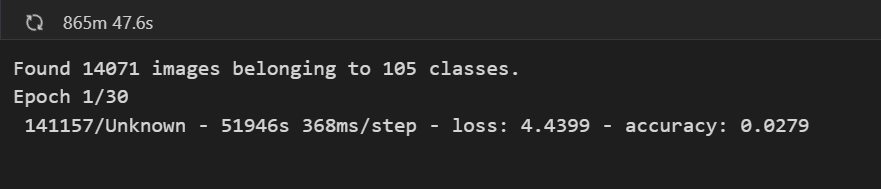

- Printing the accuracy 

- Printing classification_report

- Plotting the confustion matrix

- Plotting the loss curve

- Plotting the accuracy curve

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification report and confusion matrix
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis=1)

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot training and validation loss/accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Curves")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Curves")

plt.show()